In [1]:
# 1) Setup - install packages
!pip install -q scikit-learn pandas numpy matplotlib seaborn joblib xgboost plotly
!pip install -q shap

import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import joblib
print('Setup done')

Setup done


In [2]:
# 2) Load dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.shape


(891, 12)

                                   0  \
PassengerId                        1   
Survived                           0   
Pclass                             3   
Name         Braund, Mr. Owen Harris   
Sex                             male   
Age                             22.0   
SibSp                              1   
Parch                              0   
Ticket                     A/5 21171   
Fare                            7.25   
Cabin                            NaN   
Embarked                           S   

                                                             1  \
PassengerId                                                  2   
Survived                                                     1   
Pclass                                                       1   
Name         Cumings, Mrs. John Bradley (Florence Briggs Th...   
Sex                                                     female   
Age                                                       38.0   
SibSp            

<Axes: xlabel='Survived', ylabel='count'>

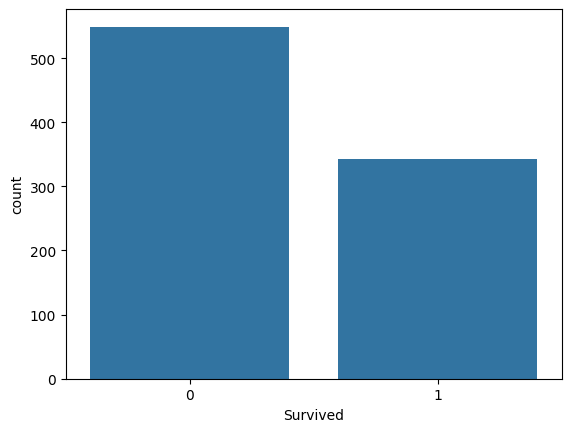

In [3]:
# 3) Quick EDA (counts & missing)
print(df.head().T)
print('\nMissing values:\n', df.isnull().sum())
sns.countplot(x='Survived', data=df)


In [4]:
# 4) Feature engineering: Title, FamilySize, IsAlone
df['Title'] = df['Name'].str.extract(',\s*([^\.]+)\.')
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
df['Title'] = df['Title'].replace(['Mme'],'Mrs')
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Other')
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1


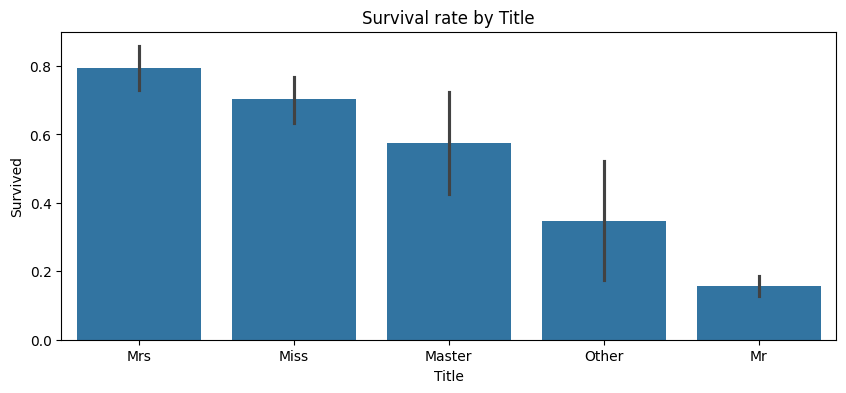

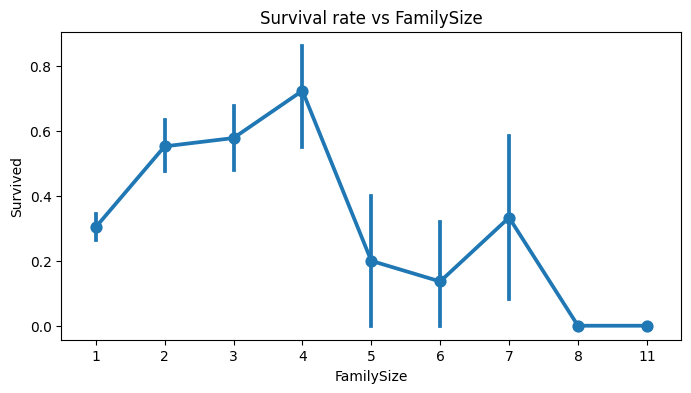

In [5]:
# 5) Visual EDA: survival by Title and FamilySize
plt.figure(figsize=(10,4))
sns.barplot(x='Title', y='Survived', data=df, order=df.groupby('Title')['Survived'].mean().sort_values(ascending=False).index)
plt.title('Survival rate by Title')
plt.show()

plt.figure(figsize=(8,4))
sns.pointplot(x='FamilySize', y='Survived', data=df)
plt.title('Survival rate vs FamilySize')
plt.show()


In [6]:
# 6) Prepare features: encoding + split
df2 = df.copy()
df2['Sex'] = df2['Sex'].map({'male':0,'female':1})
df2 = pd.get_dummies(df2, columns=['Embarked','Title'], drop_first=True)
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','FamilySize','IsAlone'] + [c for c in df2.columns if c.startswith('Embarked_') or c.startswith('Title_')]
X = df2[features]
y = df2['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape

((712, 14), (179, 14))

In [7]:
# 7) Train 3 models: LogisticRegression, RandomForest, XGBoost (if available)
models = {}
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
models['LogisticRegression'] = lr
models['RandomForest'] = rf

try:
    import xgboost as xgb
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    models['XGBoost'] = xgb_clf
    print('XGBoost available')
except Exception as e:
    print('XGBoost not available; skipping')

for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: Accuracy={acc:.4f}")

XGBoost available
LogisticRegression: Accuracy=0.8212
RandomForest: Accuracy=0.8212
XGBoost: Accuracy=0.8101


In [8]:
# 8) Hyperparameter tuning (Randomized) for RandomForest
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
}
rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1)
rs.fit(X_train, y_train)
print('Best RF params:', rs.best_params_)
best_rf = rs.best_estimator_
models['RandomForest_Tuned'] = best_rf


Best RF params: {'max_depth': 4, 'min_samples_split': 9, 'n_estimators': 393}


In [9]:
# 9) Evaluate best models and compare
import pandas as pd
results = []
for name, m in models.items():
    preds = m.predict(X_test)
    prob = m.predict_proba(X_test)[:,1] if hasattr(m, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    results.append({'model':name, 'accuracy':acc})
res_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
res_df


,model,accuracy
0,LogisticRegression,0.821229
1,RandomForest,0.821229
2,XGBoost,0.810056
3,RandomForest_Tuned,0.810056


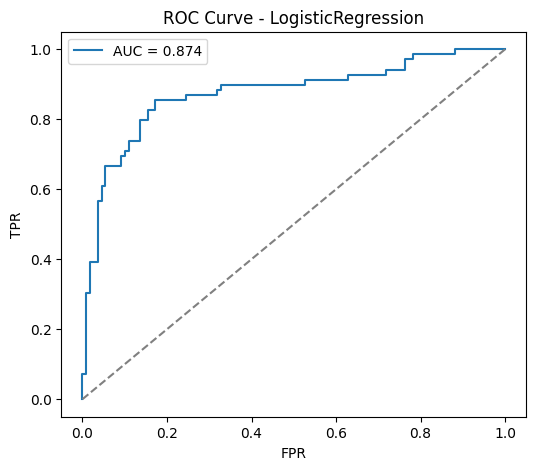

In [10]:
# 10) ROC Curve for the best model
best_name = res_df.iloc[0]['model']
best_model = models[best_name]
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve - {best_name}')
plt.legend()
plt.show()


In [11]:
# 11) Feature importance (for tree models)
if hasattr(best_model, 'feature_importances_'):
    fi = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Feature Importance')
    plt.show()
else:
    print('No feature_importances_ for', best_name)

No feature_importances_ for LogisticRegression


In [14]:
# 12) Save best model and export metrics
import os
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/best_model.joblib')
res_df.to_csv('models/model_comparison.csv', index=False)
print('Saved best model and comparison table')


Saved best model and comparison table
